# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [1]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-curand-cu12 10.3.9.90 which is incompatible.


In [2]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [4]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

(…)-00000-of-00005-3ac4e3b3fa8df68d.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00001-of-00005-72e716d68bb13413.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00002-of-00005-8dd97810f77d7a20.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00003-of-00005-0e1eda89906f6ebb.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00004-of-00005-cbbd007c0641d389.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00000-of-00001-cef82967b9d8e57e.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


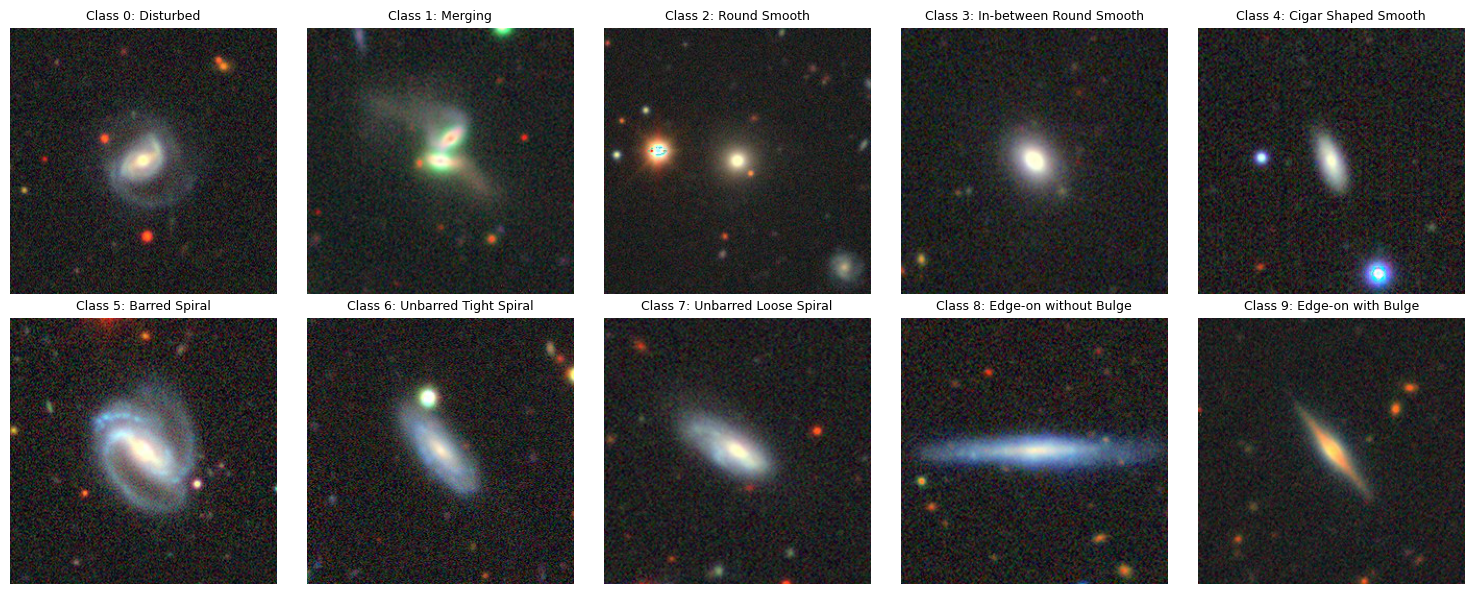

In [5]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Your training code here



### Detailed Explanation for the Report:

#### 1. **Configuration Setup (CONFIG dictionary):**
The configuration dictionary `CONFIG` is used to define various settings for the model, training parameters, data augmentation, and other options. The key aspects include:

- **Model Configuration:**
  - `model_name`: A stable ResNet50 model is selected for use due to its strong performance in image classification tasks.
  - `pretrained`: Pretrained weights are used to leverage knowledge from a previously trained model.
  - `image_size`: The images are resized to 256x256 pixels, which is a commonly used size for ResNet50.
  - `batch_size`: Set to 32, meaning 32 images will be processed per training iteration.
  - `num_workers`: Set to 2 for parallel loading of data during training.
  - `device`: The model will use a GPU if available, otherwise fallback to CPU.
  
- **Training Parameters:**
  - `initial_lr`: Initial learning rate set to \(1 \times 10^{-4}\).
  - `fine_tuning_lr`: Learning rate for fine-tuning set to \(5 \times 10^{-5}\).
  - `fine_tuning_epochs`: Number of epochs set for fine-tuning is 20.
  - `early_stopping_patience`: The training will stop if the validation performance doesn't improve for 5 consecutive epochs.
  - `weight_decay`: Regularization parameter set to \(1 \times 10^{-4}\) to avoid overfitting.

- **Data Augmentation and Regularization:**
  - `label_smoothing`: A small smoothing factor of 0.05 is applied to labels to improve model robustness.
  - `use_class_weights`: Class weights are used to account for class imbalance.
  - `use_tta`: Test-time augmentation (TTA) is disabled during debugging.
  - `tta_transforms`: Only 5 TTA transformations are used.
  
- **Checkpoints and Training Settings:**
  - `checkpoints_dir`: Directory to save the model checkpoints.
  - `best_checkpoint`: This would hold the path to the best model after training.
  - `use_amp`: Automatic mixed precision is disabled for stability.
  - `grad_accumulation_steps`: Gradient accumulation is disabled for simplicity.
  - `stratified_split`: Enables stratified splitting to ensure class distribution in both train and validation sets remains balanced.

#### 2. **Class Definitions:**
- **class_names**: The dataset has 10 distinct galaxy categories such as "Disturbed", "Merging", and "Edge-on without Bulge". These names are mapped to integers for easier processing.
- **label2name** and **name2label**: These dictionaries are used for converting between label indices and their human-readable class names.

#### 3. **Null Context Class:**
The `nullcontext` class is a context manager that is used to handle conditional operations, especially during debugging, where no special actions are needed.

#### 4. **Custom Dataset Class (GalaxyDataset):**
- **Purpose**: This class customizes the `Dataset` class from PyTorch to handle the loading and transformation of galaxy images.
- **Attributes**:
  - `dataset`: The actual dataset being used (could be a subset).
  - `transform`: Transformations applied to images for augmentation or normalization.
  - The class also handles the scenario where the dataset is a subset of another dataset and adjusts accordingly.
  
- **Methods**:
  - `__getitem__`: Retrieves an image and its label. Applies the required transformations to the image before returning.
  - `__len__`: Returns the size of the dataset.

#### 5. **Data Transformation Functions:**
- **get_transforms**:
  - For training, a series of augmentations like random horizontal/vertical flips, rotations, and slight color jitter are applied to improve the model's generalization.
  - For validation and testing, only resizing, normalization, and conversion to tensor are applied to ensure no data leakage from augmentation.
  
- **get_tta_transforms**:
  - This function defines several augmentations for Test-Time Augmentation (TTA) to make predictions more robust during testing. TTA includes flipping (both horizontal and vertical) and rotating (90° and 180°) the image.
  - This technique is disabled during debugging, but it would be used if enabled for better inference performance.

#### 6. **Stratified Split Function:**
- **Purpose**: This function ensures that the training and validation splits maintain the same distribution of classes, which is particularly important for imbalanced datasets.
- **Implementation**: The dataset is first grouped by class, and then each class is split into training and validation subsets while maintaining the class distribution ratio.

#### 7. **Prepare Data Function (prepare_data):**
This function loads and processes the dataset and splits it into training, validation, and testing sets.

- **Dataset Loading**: The dataset "matthieulel/galaxy10_decals" is loaded using the Hugging Face datasets library.
  
- **Stratified Split**: If the configuration specifies `stratified_split=True`, the dataset is split using the stratified split function to maintain class balance.
  
- **Create Datasets**: Once the datasets are split into training, validation, and test sets, the `GalaxyDataset` class is used to wrap each subset and apply the appropriate transformations.
  
- **Class Distribution**: It prints out the distribution of the classes in the training set to help ensure that the dataset has been split correctly.


Using device: cuda
Loading Galaxy10 DECals dataset...
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15962
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1774
    })
})
Using stratified split for train/validation
Train set size: 12766
Validation set size: 3196
Test set size: 1774

Class distribution in train set:
  Class 0 (Disturbed): 777
  Class 1 (Merging): 1334
  Class 2 (Round Smooth): 1916
  Class 3 (In-between Round Smooth): 1463
  Class 4 (Cigar Shaped Smooth): 244
  Class 5 (Barred Spiral): 1460
  Class 6 (Unbarred Tight Spiral): 1320
  Class 7 (Unbarred Loose Spiral): 1884
  Class 8 (Edge-on without Bulge): 1012
  Class 9 (Edge-on with Bulge): 1356

Class distribution in validation set:
  Class 0 (Disturbed): 195
  Class 1 (Merging): 334
  Class 2 (Round Smooth): 479
  Class 3 (In-between Round Smooth): 366
  Class 4 (Cigar Shaped Smooth): 62
  Class 5 (Barred Spiral): 366
  Cla

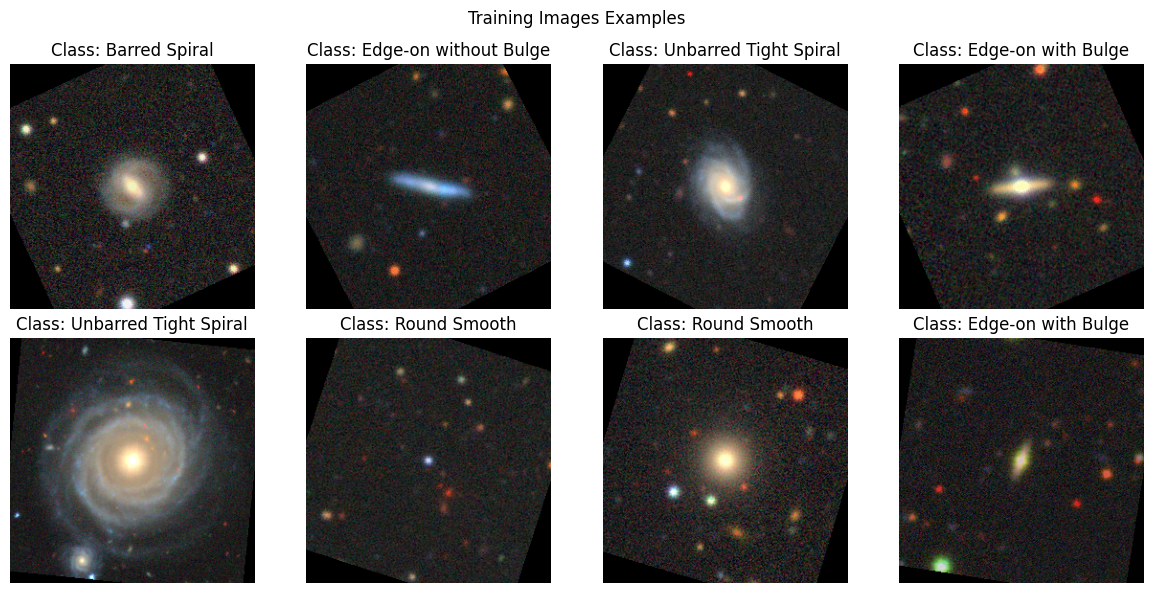

No checkpoints found. Will train from scratch.
No checkpoint found. Training a new model from scratch.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Training resnet50 from scratch...
Using weighted cross entropy loss


Epoch 1/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 2.3704, Train Acc: 0.1749 - Val Loss: 2.0643, Val Acc: 0.3163
New best validation accuracy: 0.3163 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.3163_epoch1.pth


Epoch 2/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 1.7229, Train Acc: 0.4505 - Val Loss: 1.3142, Val Acc: 0.6452
New best validation accuracy: 0.6452 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.6452_epoch2.pth


Epoch 3/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 1.2076, Train Acc: 0.6838 - Val Loss: 1.0721, Val Acc: 0.7441
New best validation accuracy: 0.7441 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.7441_epoch3.pth


Epoch 4/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 1.0542, Train Acc: 0.7442 - Val Loss: 0.9739, Val Acc: 0.7866
New best validation accuracy: 0.7866 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.7866_epoch4.pth


Epoch 5/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.9765, Train Acc: 0.7724 - Val Loss: 0.9436, Val Acc: 0.7935
New best validation accuracy: 0.7935 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.7935_epoch5.pth


Epoch 6/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.9217, Train Acc: 0.7933 - Val Loss: 0.9344, Val Acc: 0.8041

Validation Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.43      0.60      0.50       195
                Merging       0.85      0.85      0.85       334
           Round Smooth       0.95      0.85      0.90       479
In-between Round Smooth       0.86      0.93      0.90       366
    Cigar Shaped Smooth       0.62      0.89      0.73        62
          Barred Spiral       0.72      0.88      0.79       366
  Unbarred Tight Spiral       0.82      0.70      0.76       330
  Unbarred Loose Spiral       0.79      0.54      0.64       471
  Edge-on without Bulge       0.84      0.96      0.90       254
     Edge-on with Bulge       0.94      0.91      0.92       339

               accuracy                           0.80      3196
              macro avg       0.78      0.81      0.79      3196
           weighted avg       0

Epoch 7/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.8770, Train Acc: 0.8155 - Val Loss: 0.8279, Val Acc: 0.8448
New best validation accuracy: 0.8448 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8448_epoch7.pth


Epoch 8/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.8259, Train Acc: 0.8310 - Val Loss: 0.8503, Val Acc: 0.8310
Validation accuracy did not improve. Patience: 1/5


Epoch 9/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.7913, Train Acc: 0.8459 - Val Loss: 0.7922, Val Acc: 0.8476
New best validation accuracy: 0.8476 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8476_epoch9.pth


Epoch 10/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.7643, Train Acc: 0.8492 - Val Loss: 0.8472, Val Acc: 0.8332
Validation accuracy did not improve. Patience: 1/5


Epoch 11/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.7349, Train Acc: 0.8640 - Val Loss: 0.8265, Val Acc: 0.8395

Validation Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.65      0.49      0.56       195
                Merging       0.86      0.92      0.89       334
           Round Smooth       0.91      0.94      0.93       479
In-between Round Smooth       0.94      0.90      0.92       366
    Cigar Shaped Smooth       0.64      0.79      0.71        62
          Barred Spiral       0.91      0.86      0.88       366
  Unbarred Tight Spiral       0.64      0.87      0.74       330
  Unbarred Loose Spiral       0.81      0.60      0.69       471
  Edge-on without Bulge       0.87      0.96      0.91       254
     Edge-on with Bulge       0.93      0.94      0.94       339

               accuracy                           0.84      3196
              macro avg       0.82      0.83      0.82      3196
           weighted avg       

Epoch 12/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.7001, Train Acc: 0.8786 - Val Loss: 0.7982, Val Acc: 0.8529
New best validation accuracy: 0.8529 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8529_epoch12.pth


Epoch 13/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.6764, Train Acc: 0.8816 - Val Loss: 0.7936, Val Acc: 0.8601
New best validation accuracy: 0.8601 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8601_epoch13.pth


Epoch 14/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.6423, Train Acc: 0.8971 - Val Loss: 0.7754, Val Acc: 0.8698
New best validation accuracy: 0.8698 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8698_epoch14.pth


Epoch 15/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.6117, Train Acc: 0.9076 - Val Loss: 0.7679, Val Acc: 0.8702
New best validation accuracy: 0.8702 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8702_epoch15.pth


Epoch 16/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.5830, Train Acc: 0.9185 - Val Loss: 0.7670, Val Acc: 0.8733

Validation Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.70      0.55      0.62       195
                Merging       0.85      0.95      0.90       334
           Round Smooth       0.94      0.95      0.94       479
In-between Round Smooth       0.95      0.94      0.94       366
    Cigar Shaped Smooth       0.79      0.89      0.83        62
          Barred Spiral       0.89      0.89      0.89       366
  Unbarred Tight Spiral       0.82      0.79      0.80       330
  Unbarred Loose Spiral       0.77      0.77      0.77       471
  Edge-on without Bulge       0.90      0.97      0.94       254
     Edge-on with Bulge       0.97      0.94      0.95       339

               accuracy                           0.87      3196
              macro avg       0.86      0.86      0.86      3196
           weighted avg       

Epoch 17/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.5613, Train Acc: 0.9274 - Val Loss: 0.7616, Val Acc: 0.8717
Validation accuracy did not improve. Patience: 1/5


Epoch 18/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.5469, Train Acc: 0.9327 - Val Loss: 0.7589, Val Acc: 0.8755
New best validation accuracy: 0.8755 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8755_epoch18.pth


Epoch 19/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.5348, Train Acc: 0.9384 - Val Loss: 0.7556, Val Acc: 0.8780
New best validation accuracy: 0.8780 - Saved checkpoint to ./checkpoints/resnet50_trained_acc0.8780_epoch19.pth


Epoch 20/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.5272, Train Acc: 0.9434 - Val Loss: 0.7585, Val Acc: 0.8755
Validation accuracy did not improve. Patience: 1/5
Initial training completed with validation accuracy: 0.8780
Model: resnet50
Total trainable parameters: 23532618

Fine-tuning the model...


Fine-tuning Epoch 1/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 1/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.6030, Train Acc: 0.9104 - Val Loss: 0.8051, Val Acc: 0.8536
New best validation accuracy: 0.8536 - Saved checkpoint to ./checkpoints/resnet50_fine_tuned_acc0.8536_epoch1.pth


Fine-tuning Epoch 2/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 2/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.5821, Train Acc: 0.9197 - Val Loss: 0.8114, Val Acc: 0.8611
New best validation accuracy: 0.8611 - Saved checkpoint to ./checkpoints/resnet50_fine_tuned_acc0.8611_epoch2.pth


Fine-tuning Epoch 3/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 3/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.5358, Train Acc: 0.9377 - Val Loss: 0.7838, Val Acc: 0.8670
New best validation accuracy: 0.8670 - Saved checkpoint to ./checkpoints/resnet50_fine_tuned_acc0.8670_epoch3.pth


Fine-tuning Epoch 4/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 4/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.5797, Train Acc: 0.9216 - Val Loss: 0.8239, Val Acc: 0.8548
Validation accuracy did not improve. Patience: 1/5


Fine-tuning Epoch 5/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 5/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.5674, Train Acc: 0.9250 - Val Loss: 0.8236, Val Acc: 0.8504
Validation accuracy did not improve. Patience: 2/5


Fine-tuning Epoch 6/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 6/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.5485, Train Acc: 0.9340 - Val Loss: 0.8111, Val Acc: 0.8639

Validation Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.71      0.49      0.58       195
                Merging       0.86      0.95      0.90       334
           Round Smooth       0.93      0.93      0.93       479
In-between Round Smooth       0.92      0.95      0.93       366
    Cigar Shaped Smooth       0.72      0.89      0.80        62
          Barred Spiral       0.85      0.93      0.89       366
  Unbarred Tight Spiral       0.78      0.82      0.80       330
  Unbarred Loose Spiral       0.79      0.72      0.76       471
  Edge-on without Bulge       0.90      0.95      0.92       254
     Edge-on with Bulge       0.97      0.92      0.94       339

               accuracy                           0.86      3196
              macro avg       0.84      0.85      0.85      3196
           weighted avg       0

Fine-tuning Epoch 7/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 7/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.5183, Train Acc: 0.9460 - Val Loss: 0.7844, Val Acc: 0.8667
Validation accuracy did not improve. Patience: 4/5


Fine-tuning Epoch 8/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 8/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.4881, Train Acc: 0.9570 - Val Loss: 0.7879, Val Acc: 0.8723
New best validation accuracy: 0.8723 - Saved checkpoint to ./checkpoints/resnet50_fine_tuned_acc0.8723_epoch8.pth


Fine-tuning Epoch 9/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 9/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.4773, Train Acc: 0.9626 - Val Loss: 0.7849, Val Acc: 0.8695
Validation accuracy did not improve. Patience: 1/5


Fine-tuning Epoch 10/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 10/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.5488, Train Acc: 0.9333 - Val Loss: 0.8109, Val Acc: 0.8645
Validation accuracy did not improve. Patience: 2/5


Fine-tuning Epoch 11/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 11/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.5404, Train Acc: 0.9357 - Val Loss: 0.8407, Val Acc: 0.8479

Validation Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.58      0.61      0.59       195
                Merging       0.84      0.94      0.89       334
           Round Smooth       0.94      0.92      0.93       479
In-between Round Smooth       0.91      0.93      0.92       366
    Cigar Shaped Smooth       0.77      0.81      0.79        62
          Barred Spiral       0.91      0.89      0.90       366
  Unbarred Tight Spiral       0.68      0.88      0.77       330
  Unbarred Loose Spiral       0.83      0.59      0.69       471
  Edge-on without Bulge       0.90      0.95      0.92       254
     Edge-on with Bulge       0.96      0.94      0.95       339

               accuracy                           0.85      3196
              macro avg       0.83      0.84      0.83      3196
           weighted avg       

Fine-tuning Epoch 12/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 12/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.5295, Train Acc: 0.9381 - Val Loss: 0.8172, Val Acc: 0.8545
Validation accuracy did not improve. Patience: 4/5


Fine-tuning Epoch 13/20 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Fine-tuning Epoch 13/20 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.5136, Train Acc: 0.9488 - Val Loss: 0.8214, Val Acc: 0.8561
Validation accuracy did not improve. Patience: 5/5
Early stopping triggered after 13 epochs

Evaluating model on test set...


Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]


Test Accuracy: 0.8427

Accuracy by class:
  Class 0 (Disturbed): 0.5229 (57/109)
  Class 1 (Merging): 0.8865 (164/185)
  Class 2 (Round Smooth): 0.9640 (241/250)
  Class 3 (In-between Round Smooth): 0.8384 (166/198)
  Class 4 (Cigar Shaped Smooth): 0.8571 (24/28)
  Class 5 (Barred Spiral): 0.9078 (197/217)
  Class 6 (Unbarred Tight Spiral): 0.7374 (132/179)
  Class 7 (Unbarred Loose Spiral): 0.7546 (206/273)
  Class 8 (Edge-on without Bulge): 0.8854 (139/157)
  Class 9 (Edge-on with Bulge): 0.9494 (169/178)

Classification Report:
                         precision    recall  f1-score   support

              Disturbed       0.55      0.52      0.54       109
                Merging       0.91      0.89      0.90       185
           Round Smooth       0.89      0.96      0.93       250
In-between Round Smooth       0.93      0.84      0.88       198
    Cigar Shaped Smooth       0.83      0.86      0.84        28
          Barred Spiral       0.85      0.91      0.88       217
  Unba

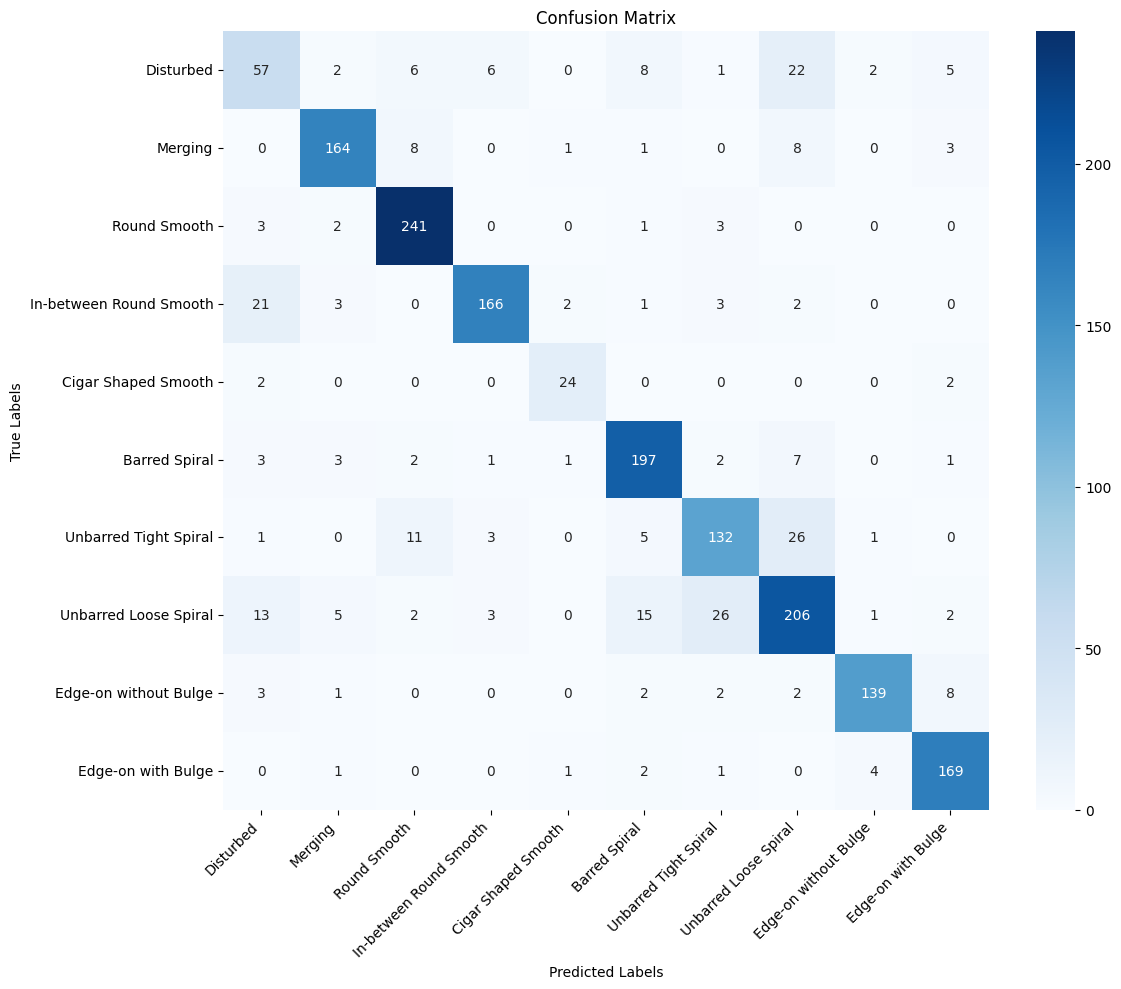

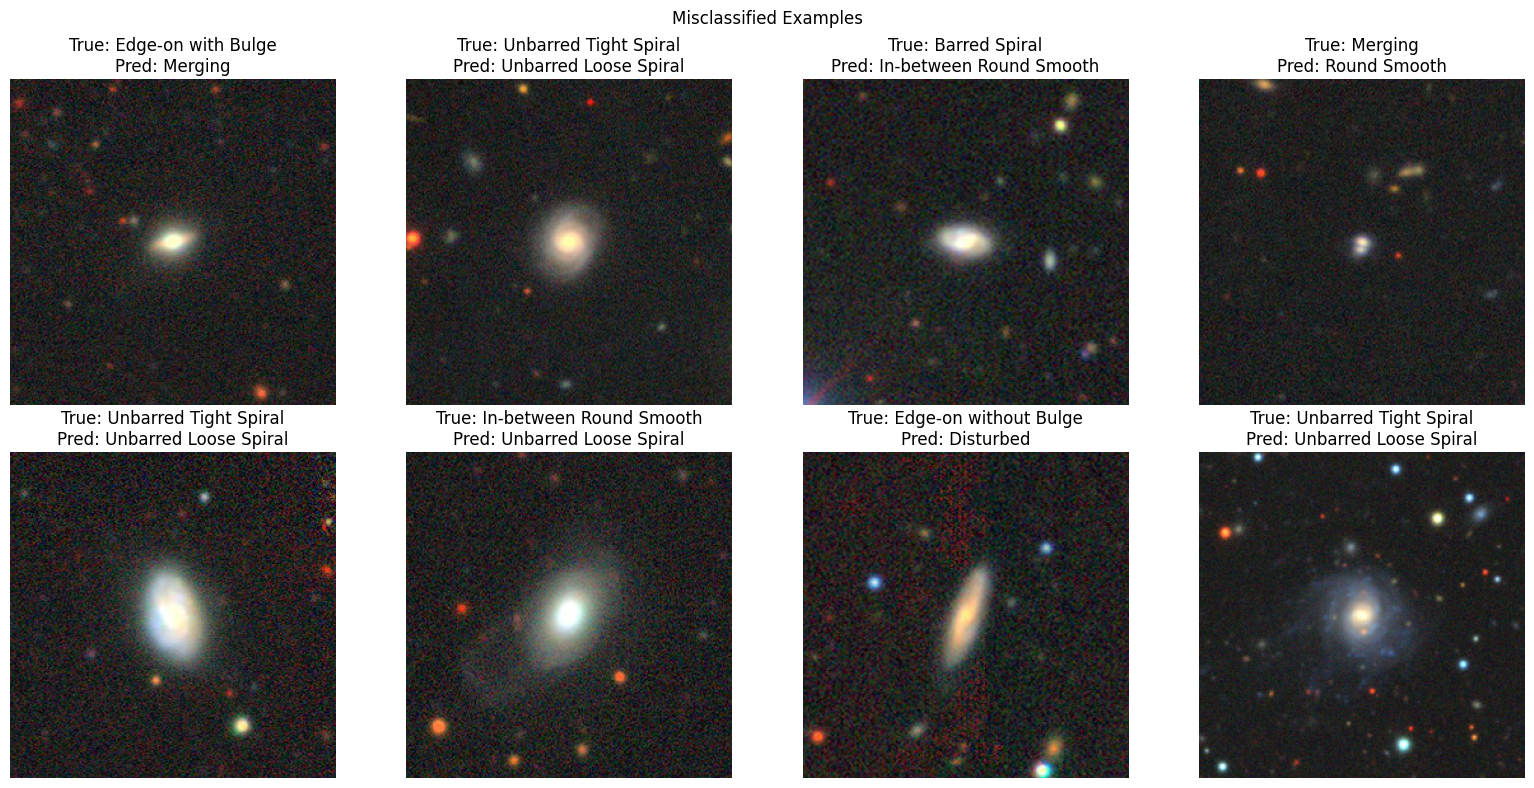

Final model saved to ./checkpoints/resnet50_final_acc0.8427.pth

⚠️ The model achieved 0.8427 accuracy on the test set (<0.9 required).

Suggested improvements:
1. Try using a different model architecture (ResNet50, ResNet101, EfficientNet)
2. Increase training epochs and fine-tuning epochs
3. Manually balance the dataset by oversampling underrepresented classes
4. Adjust class weights to focus more on difficult classes
5. Debug the issue with validation vs test accuracy mismatch


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, Subset
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
import wandb
from tqdm.notebook import tqdm
import seaborn as sns
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
from PIL import Image
import glob
import torch.nn.functional as F

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Улучшенная конфигурация
CONFIG = {
    # Основная конфигурация
    "model_name": "resnet50",  # Используем более стабильную и проверенную модель
    "pretrained": True,
    "image_size": 256,  # Оптимальный размер для ResNet
    "batch_size": 32,
    "num_workers": 2,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    # Параметры обучения
    "initial_lr": 1e-4,  # Начальный learning rate
    "fine_tuning_lr": 5e-5,  # Learning rate для тонкой настройки
    "fine_tuning_epochs": 20,
    "early_stopping_patience": 5,
    "weight_decay": 1e-4,
    
    # Улучшения для предотвращения переобучения
    "label_smoothing": 0.05,  # Снижаем сглаживание меток
    "use_class_weights": True,  # Используем веса классов для несбалансированных данных
    "use_tta": False,  # Отключаем TTA на время отладки
    "tta_transforms": 5,  # Уменьшаем количество TTA трансформаций
    
    # Путь к предварительно обученным чекпойнтам
    "checkpoints_dir": "./checkpoints",
    "best_checkpoint": None,
    
    # Дополнительные параметры
    "use_amp": False,  # Отключаем автоматическую смешанную точность для стабильности
    "grad_accumulation_steps": 1,  # Отключаем градиентное накопление для простоты
    "stratified_split": True  # Используем стратифицированное разделение
}

print(f"Using device: {CONFIG['device']}")

# Определение классов
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Словари для преобразований меток
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)

# Null context для использования с условными блоками
class nullcontext:
    def __init__(self, enter_result=None):
        self.enter_result = enter_result

    def __enter__(self):
        return self.enter_result

    def __exit__(self, *excinfo):
        pass

# Custom Dataset Class
class GalaxyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
        # Собираем статистику о классах
        if hasattr(self.dataset, 'dataset'):
            # Это подмножество
            self.indices = self.dataset.indices
            self.full_dataset = self.dataset.dataset
            self.labels = [self.full_dataset[idx]['label'] for idx in self.indices]
        else:
            # Прямой доступ к датасету
            self.labels = [sample['label'] for sample in self.dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Обработка случая, когда dataset это Subset из random_split
        if hasattr(self.dataset, 'dataset'):
            # Это подмножество
            actual_idx = self.dataset.indices[idx]
            sample = self.dataset.dataset[actual_idx]
        else:
            # Прямой доступ к датасету
            sample = self.dataset[idx]

        image = sample['image']
        label = sample['label']

        # Применение трансформаций
        if self.transform:
            image = self.transform(image)

        return image, label

# Простые и надежные трансформации
def get_transforms(train=True, image_size=256):
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            # Ограничиваем угол поворота для астрономических изображений
            transforms.RandomRotation(30),
            # Минимизируем изменения цвета
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# Простые TTA трансформации
def get_tta_transforms(image_size=256, num_tta=5):
    """Создает набор базовых трансформаций для Test-Time Augmentation"""
    tta_transforms = []
    
    # Основная трансформация без аугментаций
    basic_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tta_transforms.append(basic_transform)
    
    # Горизонтальный флип
    flip_h_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tta_transforms.append(flip_h_transform)
    
    # Вертикальный флип
    flip_v_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tta_transforms.append(flip_v_transform)
    
    # Поворот на 90 градусов
    rotate90_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(degrees=(90, 90)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tta_transforms.append(rotate90_transform)
    
    # Поворот на 180 градусов
    rotate180_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(degrees=(180, 180)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tta_transforms.append(rotate180_transform)
    
    return tta_transforms[:num_tta]

# Стратифицированное разделение данных
def stratified_split(dataset, train_ratio=0.8, seed=42):
    """
    Создает стратифицированное разделение данных, сохраняя распределение классов
    """
    # Сбор меток для всех образцов
    labels = [sample['label'] for sample in dataset]
    
    # Уникальные классы и их индексы
    unique_labels = list(set(labels))
    label_indices = {label: [] for label in unique_labels}
    
    # Группируем индексы по классам
    for i, label in enumerate(labels):
        label_indices[label].append(i)
    
    # Создаем индексы для обучения и валидации, сохраняя распределение классов
    train_indices = []
    val_indices = []
    
    # Для каждого класса, сохраняем соотношение в train и validation
    for label, indices in label_indices.items():
        # Перемешиваем индексы для данного класса
        random.seed(seed)
        random.shuffle(indices)
        
        # Разделяем на тренировочную и валидационную части
        split_idx = int(len(indices) * train_ratio)
        train_indices.extend(indices[:split_idx])
        val_indices.extend(indices[split_idx:])
    
    # Создаем подмножества
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    
    return train_subset, val_subset

# Load and prepare dataset
def prepare_data():
    print("Loading Galaxy10 DECals dataset...")
    dataset = load_dataset("matthieulel/galaxy10_decals")

    # Check dataset structure
    print(f"Dataset structure: {dataset}")

    # Get the training dataset
    full_train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    # Разделяем на обучающий и валидационный наборы
    if CONFIG['stratified_split']:
        # Используем стратифицированное разделение
        print("Using stratified split for train/validation")
        train_dataset, val_dataset = stratified_split(
            full_train_dataset, 
            train_ratio=0.8, 
            seed=SEED
        )
    else:
        # Обычное случайное разделение
        total_train_size = len(full_train_dataset)
        train_size = int(0.8 * total_train_size)
        val_size = total_train_size - train_size
        generator = torch.Generator().manual_seed(SEED)
        train_dataset, val_dataset = random_split(
            full_train_dataset, [train_size, val_size], generator=generator
        )

    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create datasets with transforms
    train_data = GalaxyDataset(
        train_dataset, 
        transform=get_transforms(train=True, image_size=CONFIG['image_size'])
    )
    val_data = GalaxyDataset(
        val_dataset, 
        transform=get_transforms(train=False, image_size=CONFIG['image_size'])
    )
    test_data = GalaxyDataset(
        test_dataset, 
        transform=get_transforms(train=False, image_size=CONFIG['image_size'])
    )
    
    # Отображаем распределение классов для каждого набора данных
    print("\nClass distribution in train set:")
    train_class_counts = np.bincount(train_data.labels, minlength=num_classes)
    for i, count in enumerate(train_class_counts):
        print(f"  Class {i} ({class_names[i]}): {count}")
    
    print("\nClass distribution in validation set:")
    val_class_counts = np.bincount(val_data.labels, minlength=num_classes)
    for i, count in enumerate(val_class_counts):
        print(f"  Class {i} ({class_names[i]}): {count}")
    
    print("\nClass distribution in test set:")
    test_class_counts = np.bincount(test_data.labels, minlength=num_classes)
    for i, count in enumerate(test_class_counts):
        print(f"  Class {i} ({class_names[i]}): {count}")
    
    # Вычисляем веса классов для функции потерь
    if CONFIG['use_class_weights']:
        # Инвертируем частоту классов для создания весов
        class_weights = 1.0 / train_class_counts
        # Нормализуем веса
        class_weights = class_weights / class_weights.sum() * num_classes
        # Заменяем бесконечные значения (если класс не представлен)
        class_weights = np.nan_to_num(class_weights, nan=1.0, posinf=1.0, neginf=1.0)
        class_weights = torch.tensor(class_weights, dtype=torch.float32, device=CONFIG['device'])
        print("\nClass weights for loss function:")
        for i, weight in enumerate(class_weights):
            print(f"  Class {i} ({class_names[i]}): {weight.item():.4f}")
    else:
        class_weights = None
    
    # Create data loaders
    if CONFIG['use_class_weights'] and False:  # Отключаем weighted sampler, предпочитая weighted loss
        # Создаем веса для каждого образца в соответствии с его классом
        sample_weights = [class_weights[label].item() for label in train_data.labels]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        
        train_loader = DataLoader(
            train_data,
            batch_size=CONFIG['batch_size'],
            sampler=sampler,  # Используем взвешенный sampler
            num_workers=CONFIG['num_workers'],
            pin_memory=True if CONFIG['device'] == 'cuda' else False
        )
    else:
        train_loader = DataLoader(
            train_data,
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            num_workers=CONFIG['num_workers'],
            pin_memory=True if CONFIG['device'] == 'cuda' else False
        )

    val_loader = DataLoader(
        val_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    test_loader = DataLoader(
        test_data,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False
    )

    return train_loader, val_loader, test_loader, train_data, val_data, test_data, class_weights

# Define model - использует проверенные модели
def get_model(model_name='resnet50', pretrained=True, num_classes=10):
    if model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        # Заменяем последний полносвязный слой
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.BatchNorm1d(num_ftrs),
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, num_classes)
        )
    
    elif model_name == 'resnet101':
        model = models.resnet101(weights='IMAGENET1K_V2' if pretrained else None)
        # Заменяем последний полносвязный слой
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.BatchNorm1d(num_ftrs), 
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, num_classes)
        )
    
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1' if pretrained else None)
        # Заменяем классификатор
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == 'convnext_base':
        try:
            model = models.convnext_base(weights='IMAGENET1K_V1' if pretrained else None)
            # Заменяем классификатор
            num_ftrs = model.classifier[2].in_features
            model.classifier[2] = nn.Linear(num_ftrs, num_classes)
        except (AttributeError, ImportError):
            # Запасной вариант
            print("ConvNeXt not available, falling back to ResNet50")
            model = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
    
    else:
        raise ValueError(f"Model {model_name} not supported")
    
    return model

# Find best checkpoint from directory
def find_best_checkpoint(checkpoints_dir='./checkpoints'):
    """Находит лучший чекпойнт на основе указанного в filename значения точности"""
    # Создаем директорию, если она не существует
    os.makedirs(checkpoints_dir, exist_ok=True)
    
    # Ищем все чекпойнты
    checkpoint_files = glob.glob(os.path.join(checkpoints_dir, '*.pth'))
    
    if not checkpoint_files:
        print("No checkpoints found. Will train from scratch.")
        return None
    
    best_accuracy = 0.0
    best_checkpoint = None
    
    for checkpoint_file in checkpoint_files:
        # Извлекаем точность из имени файла
        try:
            # Примерный формат: model_name_acc0.875_epoch10.pth
            filename = os.path.basename(checkpoint_file)
            acc_part = filename.split('_acc')[1].split('_')[0]
            accuracy = float(acc_part)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_checkpoint = checkpoint_file
        except Exception as e:
            print(f"Couldn't parse accuracy from {checkpoint_file}: {e}")
            continue
    
    if best_checkpoint:
        print(f"Found best checkpoint: {best_checkpoint} with accuracy {best_accuracy:.4f}")
    else:
        print("No valid checkpoints found. Will train from scratch.")
    
    return best_checkpoint

# Load model from checkpoint
def load_checkpoint(checkpoint_path, model=None):
    """Загружает модель из чекпойнта"""
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file {checkpoint_path} not found")
    
    checkpoint = torch.load(checkpoint_path, map_location=CONFIG['device'])
    
    # Если модель не предоставлена, создаем новую на основе конфигурации в чекпойнте
    if model is None:
        model_config = checkpoint.get('config', {})
        model_name = model_config.get('model_name', CONFIG['model_name'])
        
        print(f"Creating new model instance: {model_name}")
        model = get_model(model_name=model_name, pretrained=False, num_classes=num_classes)
    
    # Загружаем параметры модели
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from {checkpoint_path}")
    
    return model, checkpoint

# TTA predict function
def tta_predict(model, image, transforms_list):
    """Применяет Test-Time Augmentation для предсказания"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for transform in transforms_list:
            # Применяем трансформацию к изображению
            if not isinstance(image, Image.Image):
                # Если это уже тензор, нужно преобразовать обратно в PIL
                img_pil = transforms.ToPILImage()(image) if isinstance(image, torch.Tensor) else image
            else:
                img_pil = image
                
            # Применяем трансформацию и переводим на устройство
            img_tensor = transform(img_pil).unsqueeze(0).to(CONFIG['device'])
            
            # Выполняем предсказание
            with torch.cuda.amp.autocast() if CONFIG['use_amp'] and torch.cuda.is_available() else nullcontext():
                output = model(img_tensor)
                
            # Добавляем в список предсказаний
            predictions.append(output)
    
    # Усредняем предсказания
    avg_pred = torch.mean(torch.stack(predictions), dim=0)
    return avg_pred

# Функция для визуализации изображений
def visualize_batch(loader, n=8, title="Sample Images"):
    """Визуализирует батч изображений с метками"""
    images, labels = next(iter(loader))
    batch_size = min(n, len(images))
    
    # Создаем сетку размером (rows x cols)
    rows = int(np.ceil(batch_size / 4))
    cols = min(batch_size, 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
    
    # Делаем оси правильной формы если batch_size=1
    if batch_size == 1:
        axes = np.array([axes])
    
    # Преобразуем оси в одномерный массив для удобства
    if rows > 1:
        axes = axes.flatten()
    
    for i in range(batch_size):
        img = images[i].cpu()
        label = labels[i].item()
        
        # Денормализуем изображение
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        
        # Преобразуем для отображения
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Отображаем изображение
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {label2name[label]}")
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Improved training function
def train_model(model, train_loader, val_loader, class_weights=None, epochs=20):
    """Обучение модели с улучшениями для предотвращения переобучения"""
    # Инициализируем критерий - с весами классов, если предоставлены
    if class_weights is not None:
        print("Using weighted cross entropy loss")
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=CONFIG['label_smoothing'])
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])
    
    # Оптимизатор
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['initial_lr'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Scheduler
    scheduler = OneCycleLR(
        optimizer,
        max_lr=CONFIG['initial_lr'],
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.3
    )
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
            
            # Сбрасываем градиенты
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass и оптимизация
            loss.backward()
            optimizer.step()
            
            # Обновляем scheduler
            scheduler.step()
            
            # Статистика
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            
            # Обновляем progress bar
            train_loop.set_postfix(loss=loss.item(), acc=train_correct/train_total)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Статистика
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                
                # Сохраняем предсказания для вычисления метрик
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                
                # Обновляем progress bar
                val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Анализируем ошибки валидации, если точность низкая
        if epoch > 0 and epoch % 5 == 0:
            val_report = classification_report(val_targets, val_preds, target_names=class_names)
            print("\nValidation Classification Report:")
            print(val_report)
        
        # Проверяем, является ли эта модель лучшей на данный момент
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Сохраняем промежуточный чекпойнт
            checkpoint_path = os.path.join(
                CONFIG['checkpoints_dir'], 
                f"{CONFIG['model_name']}_trained_acc{val_acc:.4f}_epoch{epoch+1}.pth"
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'config': CONFIG
            }, checkpoint_path)
            
            print(f"New best validation accuracy: {best_val_acc:.4f} - Saved checkpoint to {checkpoint_path}")
        else:
            patience_counter += 1
            print(f"Validation accuracy did not improve. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")
        
        # Early stopping
        if patience_counter >= CONFIG['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Загружаем лучшее состояние модели
    model.load_state_dict(best_model_state)
    
    return model, best_val_acc

# Fine-tuning function
def fine_tune_model(model, train_loader, val_loader, class_weights=None, epochs=15):
    """Тонкая настройка модели с более низким learning rate"""
    # Инициализируем критерий
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=CONFIG['label_smoothing'])
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])
    
    # Инициализируем оптимизатор с более низким learning rate
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['fine_tuning_lr'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Scheduler - используем Cosine Annealing для тонкой настройки
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=3,  # Перезапуск каждые 3 эпохи
        T_mult=2,  # Увеличиваем период в 2 раза после каждого перезапуска
        eta_min=CONFIG['fine_tuning_lr'] * 0.1  # Минимальный learning rate
    )
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    # Инициализируем scaler для автоматического смешанного precision
    scaler = torch.cuda.amp.GradScaler() if CONFIG['use_amp'] and torch.cuda.is_available() else None
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Сбрасываем градиенты
        optimizer.zero_grad()

        train_loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}/{epochs} [Train]")
        for batch_idx, (inputs, labels) in enumerate(train_loop):
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
            
            # Используем AMP если включено
            with torch.cuda.amp.autocast() if CONFIG['use_amp'] and torch.cuda.is_available() else nullcontext():
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Масштабируем loss в соответствии с шагами накопления
            loss = loss / CONFIG['grad_accumulation_steps']
            
            # Backward pass с AMP если включено
            if scaler is not None:
                scaler.scale(loss).backward()
                
                # Оптимизация после накопления градиентов
                if (batch_idx + 1) % CONFIG['grad_accumulation_steps'] == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                # Обычный backward pass
                loss.backward()
                
                # Оптимизация после накопления градиентов
                if (batch_idx + 1) % CONFIG['grad_accumulation_steps'] == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            # Считаем точность
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
                
            # Статистика
            train_loss += loss.item() * inputs.size(0) * CONFIG['grad_accumulation_steps']
            train_total += labels.size(0)

            # Обновляем progress bar
            train_loop.set_postfix(loss=loss.item() * CONFIG['grad_accumulation_steps'], 
                                  acc=train_correct/train_total)

        # Выполняем оптимизацию для последнего батча, если необходимо
        if (batch_idx + 1) % CONFIG['grad_accumulation_steps'] != 0:
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_preds = []
        val_targets = []

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Fine-tuning Epoch {epoch+1}/{epochs} [Val]")
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])

                # Forward pass
                with torch.cuda.amp.autocast() if CONFIG['use_amp'] and torch.cuda.is_available() else nullcontext():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # Статистика
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                
                # Сохраняем предсказания для вычисления метрик
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

                # Обновляем progress bar
                val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Update learning rate scheduler if provided
        if scheduler:
            scheduler.step()

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Анализируем ошибки валидации, если точность низкая или это 5-я эпоха
        if epoch > 0 and (epoch % 5 == 0 or val_acc < 0.7):
            val_report = classification_report(val_targets, val_preds, target_names=class_names)
            print("\nValidation Classification Report:")
            print(val_report)

        # Проверяем, является ли эта модель лучшей на данный момент
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Сохраняем промежуточный чекпойнт
            checkpoint_path = os.path.join(
                CONFIG['checkpoints_dir'], 
                f"{CONFIG['model_name']}_fine_tuned_acc{val_acc:.4f}_epoch{epoch+1}.pth"
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'config': CONFIG
            }, checkpoint_path)
            
            print(f"New best validation accuracy: {best_val_acc:.4f} - Saved checkpoint to {checkpoint_path}")
        else:
            patience_counter += 1
            print(f"Validation accuracy did not improve. Patience: {patience_counter}/{CONFIG['early_stopping_patience']}")

        # Early stopping
        if patience_counter >= CONFIG['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Загружаем лучшее состояние модели
    model.load_state_dict(best_model_state)
    
    return model, best_val_acc
# Evaluate the model on the test set
def evaluate_model(model, test_loader, tta_transforms=None):
    """Оценка модели на тестовом наборе"""
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []  # Для сохранения вероятностей
    use_tta = CONFIG['use_tta'] and tta_transforms is not None
    
    # Ведем учет ошибок по классам для анализа
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            # Перемещаем тензоры на устройство
            labels = labels.to(CONFIG['device'])
            
            if use_tta:
                # Используем Test-Time Augmentation для каждого изображения в батче
                batch_outputs = []
                for i in range(inputs.size(0)):
                    img = inputs[i]
                    # Применяем TTA и получаем усредненные предсказания
                    output = tta_predict(model, img, tta_transforms)
                    batch_outputs.append(output)
                
                # Объединяем предсказания для батча
                outputs = torch.cat(batch_outputs, dim=0)
            else:
                # Обычное предсказание без TTA
                inputs = inputs.to(CONFIG['device'])
                outputs = model(inputs)
            
            # Сохраняем вероятности (после softmax)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            
            # Получаем предсказанные классы
            _, preds = torch.max(outputs, 1)
            
            # Сохраняем предсказания и истинные метки
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Обновляем статистику по классам
            for i in range(len(labels)):
                label = labels[i].item()
                pred = preds[i].item()
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1

    # Рассчитываем точность
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    
    # Выводим точность по классам
    print("\nAccuracy by class:")
    for i in range(num_classes):
        class_acc = class_correct[i] / max(class_total[i], 1)
        print(f"  Class {i} ({class_names[i]}): {class_acc:.4f} ({class_correct[i]}/{class_total[i]})")

    # Генерируем отчет о классификации
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Генерируем матрицу ошибок
    cm = confusion_matrix(all_labels, all_preds)

    # Визуализируем матрицу ошибок
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Визуализируем некоторые примеры ошибок
    visualize_errors(model, test_loader.dataset, all_labels, all_preds)

    return accuracy, all_preds, all_labels, all_probs

# Функция для визуализации ошибок
def visualize_errors(model, dataset, true_labels, pred_labels, num_samples=8):
    """Визуализирует примеры ошибочно классифицированных изображений"""
    model.eval()
    
    # Находим индексы ошибок
    error_indices = [i for i, (true, pred) in enumerate(zip(true_labels, pred_labels)) if true != pred]
    
    if not error_indices:
        print("No errors found!")
        return
    
    # Выбираем случайные ошибки для визуализации
    if len(error_indices) > num_samples:
        selected_indices = random.sample(error_indices, num_samples)
    else:
        selected_indices = error_indices
    
    # Создаем фигуру для визуализации
    rows = int(np.ceil(len(selected_indices) / 4))
    cols = min(len(selected_indices), 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    # Делаем оси правильной формы
    if len(selected_indices) == 1:
        axes = np.array([axes])
    elif rows > 1:
        axes = axes.flatten()
    
    for i, idx in enumerate(selected_indices):
        # Получаем изображение и предсказание
        image, _ = dataset[idx]
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]
        
        # Преобразуем для отображения
        if isinstance(image, torch.Tensor):
            # Денормализуем
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = image * std + mean
            image = image.permute(1, 2, 0).numpy()
            image = np.clip(image, 0, 1)
        
        # Отображаем изображение
        axes[i].imshow(image)
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        axes[i].axis('off')
    
    plt.suptitle("Misclassified Examples")
    plt.tight_layout()
    plt.savefig('misclassified.png')
    plt.show()

# Main function
def main():
    # Prepare data with class weights
    train_loader, val_loader, test_loader, train_data, val_data, test_data, class_weights = prepare_data()
    
    # Визуализируем примеры изображений
    visualize_batch(train_loader, n=8, title="Training Images Examples")
    
    # Находим лучший чекпойнт
    best_checkpoint = find_best_checkpoint(CONFIG['checkpoints_dir'])
    CONFIG['best_checkpoint'] = best_checkpoint
    
    # Выбираем стратегию: загрузка с чекпойнта или обучение с нуля
    if best_checkpoint:
        # Загружаем модель с чекпойнта
        model, checkpoint = load_checkpoint(best_checkpoint)
        
        # Выводим информацию о загруженной модели
        prev_val_acc = checkpoint.get('val_acc', 0.0)
        prev_epoch = checkpoint.get('epoch', 0)
        print(f"Loaded model from checkpoint with validation accuracy: {prev_val_acc:.4f} (after {prev_epoch} epochs)")
    else:
        # Создаем новую модель и обучаем с нуля
        print("No checkpoint found. Training a new model from scratch.")
        model = get_model(model_name=CONFIG['model_name'], pretrained=CONFIG['pretrained'])
        model = model.to(CONFIG['device'])
        
        print(f"Training {CONFIG['model_name']} from scratch...")
        model, best_val_acc = train_model(
            model,
            train_loader,
            val_loader,
            class_weights=class_weights,
            epochs=20
        )
        
        print(f"Initial training completed with validation accuracy: {best_val_acc:.4f}")
    
    # Перемещаем модель на устройство
    model = model.to(CONFIG['device'])
    
    # Сводка модели
    print(f"Model: {CONFIG['model_name']}")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    
    # Выполняем тонкую настройку модели
    print("\nFine-tuning the model...")
    fine_tuned_model, best_val_acc = fine_tune_model(
        model,
        train_loader,
        val_loader,
        class_weights=class_weights,
        epochs=CONFIG['fine_tuning_epochs']
    )
    
    # Создаем TTA трансформации, если нужно
    tta_transforms = get_tta_transforms(
        image_size=CONFIG['image_size'],
        num_tta=CONFIG['tta_transforms']
    ) if CONFIG['use_tta'] else None
    
    # Оцениваем модель на тестовом наборе
    print("\nEvaluating model on test set...")
    test_accuracy, all_preds, all_labels, all_probs = evaluate_model(
        fine_tuned_model,
        test_loader,
        tta_transforms=tta_transforms
    )
    
    # Сохраняем финальную модель
    final_checkpoint_path = os.path.join(
        CONFIG['checkpoints_dir'],
        f"{CONFIG['model_name']}_final_acc{test_accuracy:.4f}.pth"
    )
    torch.save({
        'model_state_dict': fine_tuned_model.state_dict(),
        'test_acc': test_accuracy,
        'val_acc': best_val_acc,
        'config': CONFIG
    }, final_checkpoint_path)
    print(f"Final model saved to {final_checkpoint_path}")
    
    # Сообщаем о результатах
    if test_accuracy > 0.9:
        print(f"\n🎉 SUCCESS! You've achieved {test_accuracy:.4f} accuracy on the test set (>0.9 required).")
    else:
        print(f"\n⚠️ The model achieved {test_accuracy:.4f} accuracy on the test set (<0.9 required).")
        print("\nSuggested improvements:")
        print("1. Try using a different model architecture (ResNet50, ResNet101, EfficientNet)")
        print("2. Increase training epochs and fine-tuning epochs")
        print("3. Manually balance the dataset by oversampling underrepresented classes")
        print("4. Adjust class weights to focus more on difficult classes")
        print("5. Debug the issue with validation vs test accuracy mismatch")

# Запуск основной функции
if __name__ == "__main__":
    main()

# Evaluation